In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [2]:
from __future__ import annotations
import numpy as np
import random
import copy

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve

## Set up network

In [3]:
## Parameters

task_type='Iris_classification'
# task_type='Regression'

Nin: int = 2
Ninter: int = 0
Nout: int = 2


# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 0.05  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

R_update: str = 'propto'
# R_update = 'deltaR'
R_vec_i = array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 3., 0.85, 1.05, 0.9, 1, 0.85, 1.05, 1., 2.95, 0.55])

# training length
iterations = 400  # number of sampled of p
    
supress_prints: bool = True
bc_noise: float = 0.0
# use_p_tag: bool = True
use_p_tag: bool = False
    
M_values: np.ndarray = array([0.4, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])
    
## Networkx sizes
scale: float = 5.0
squish: float = 0.01

In [4]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         Nout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         supress_prints, \
                         bc_noise, \
                         task_type, \
                         M_values, \
                         Ninter)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(M_values)

mismatched # of inputs and outputs for Iris classification. correcting accordingly to Nin=4 Nout=3
alpha_vec [0.05 0.05 0.05]


In [5]:
## Assign input and output nodes a.f.o lattice size and row choice
input_nodes_arr, inter_nodes_arr, output_nodes_arr, ground_nodes_arr = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs.Ninter, Variabs.Nout)

In [6]:
print('input_nodes_arr ', input_nodes_arr)
print('inter_nodes_arr ', inter_nodes_arr)
print('output_nodes_arr ', output_nodes_arr)
print('ground_nodes_arr ', ground_nodes_arr)

input_nodes_arr  [0 1 2 3]
inter_nodes_arr  []
output_nodes_arr  [4 5 6]
ground_nodes_arr  [7]


In [7]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [8]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(input_nodes_arr, \
                           output_nodes_arr, \
                           inter_nodes_arr, \
                           ground_nodes_arr,)
Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [9]:
## Initiate internal flow network state class

State = Network_State(Variabs.Nin, Variabs.Nout)
State.initiate_resistances(BigClass, R_vec_i)
BigClass.add_State(State)  # add to big class

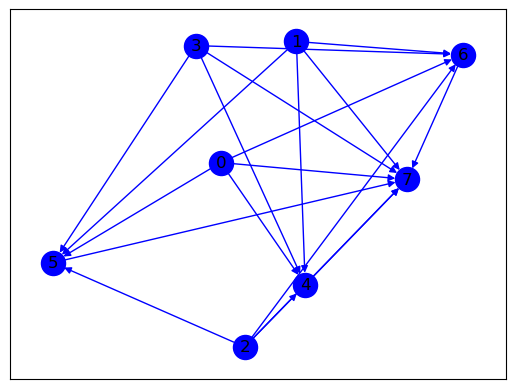

NET is ready


In [10]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=True)
BigClass.add_NET(NET)  # add to big class

## Train

In [11]:
for i in range(Variabs.iterations):
    # print('i', i)
    # if task is classification and iteration # is beginning of epoch
    # draw output of network as output of mean of Irises
    if i % 30 == 0 and task_type == 'Iris_classification':
        targets_mat = zeros([3, 3])
        for j in range(3):
            State.draw_p_means_Iris(Variabs, j)
            # print('means[j]', State.input_drawn)
            State.solve_flow_given_problem(BigClass, "measure_for_mean")  # measure and don't change resistances
            # print('targets[j]', State.output)
            targets_mat[j] = State.output
        State.assign_targets_Iris(targets_mat)
        print(targets_mat)
    State.draw_p_in_and_desired(Variabs, i)
    #print('p_drawn ', State.input_drawn)
    # print('desired output', State.desired)
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    # print('output meausred', State.output)
    if not i % 2:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.calc_loss(BigClass)
        State.update_pressure_dual(BigClass)
        State.update_output_dual(BigClass)
        State.solve_flow_given_problem(BigClass, "dual")  # measure and don't change resistances
        State.update_Rs(BigClass)

[[2.55772773 2.4774566  2.59511746]
 [3.4389039  3.38033671 3.35006445]
 [4.01324928 4.0208056  3.85736187]]
[[2.51556101 2.51764396 2.52426797]
 [2.65469506 2.67473253 2.73724593]
 [2.75227552 2.78492025 2.88670611]]
[[2.49952317 2.49967596 2.5005344 ]
 [2.49486077 2.49650826 2.50575092]
 [2.49159874 2.49429197 2.50940082]]
[[2.49999373 2.49999547 2.50001001]
 [2.49993242 2.49995115 2.50010783]
 [2.49988952 2.49992014 2.50017627]]
[[2.50000195 2.50000141 2.4999969 ]
 [2.50002095 2.50001515 2.49996658]
 [2.50003426 2.50002476 2.49994537]]
[[2.49999924 2.49999945 2.50000122]
 [2.49999178 2.49999406 2.50001311]
 [2.49998656 2.49999029 2.50002143]]
[[2.50000016 2.50000012 2.49999974]
 [2.50000177 2.50000128 2.49999718]
 [2.50000289 2.50000209 2.49999539]]
[[2.5        2.5        2.50000001]
 [2.49999996 2.49999997 2.50000006]
 [2.49999993 2.49999995 2.50000011]]
[[2.5 2.5 2.5]
 [2.5 2.5 2.5]
 [2.5 2.5 2.5]]
[[2.5 2.5 2.5]
 [2.5 2.5 2.5]
 [2.5 2.5 2.5]]
[[2.5 2.5 2.5]
 [2.5 2.5 2.5]
 [2.5 

## Plots

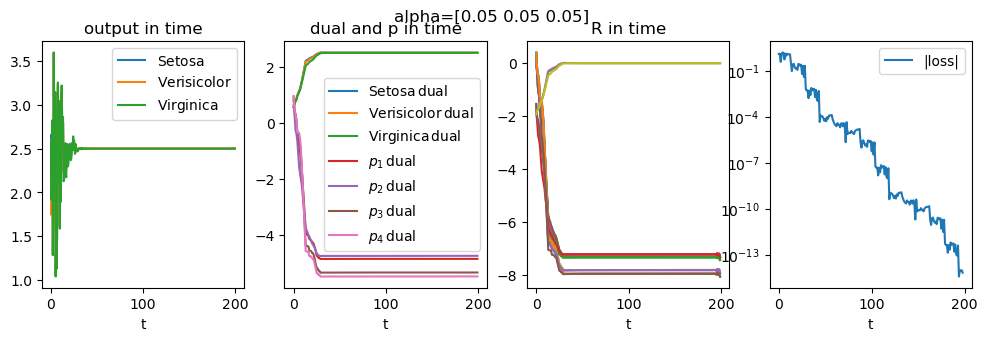

In [12]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M)
else:
        plot_functions.plot_importants(State, Variabs, State.desired_in_t)

## Statistics

### Error

In [13]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

final_err 6.186826606580099e-11


### Accuracy

In [14]:
accuracy = zeros(np.shape(Variabs.dataset)[0])
for i, datapoint in enumerate(Variabs.dataset):
    State.draw_p_in_and_desired(Variabs, i)
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    print('State.output', State.output)
    print('State.target_mat', State.target_mat)
    print('Variabs.targets[i]', Variabs.targets[i])
    accuracy[i] = statistics.calculate_accuracy(State.output, State.target_mat, Variabs.targets[i])

State.output [2.5 2.5 2.5]
State.target_mat [[2.5 2.5 2.5]
 [2.5 2.5 2.5]
 [2.5 2.5 2.5]]
Variabs.targets[i] [0. 1. 0.]
State.output [2.5 2.5 2.5]
State.target_mat [[2.5 2.5 2.5]
 [2.5 2.5 2.5]
 [2.5 2.5 2.5]]
Variabs.targets[i] [1. 0. 0.]
State.output [2.5 2.5 2.5]
State.target_mat [[2.5 2.5 2.5]
 [2.5 2.5 2.5]
 [2.5 2.5 2.5]]
Variabs.targets[i] [0. 0. 1.]
State.output [2.5 2.5 2.5]
State.target_mat [[2.5 2.5 2.5]
 [2.5 2.5 2.5]
 [2.5 2.5 2.5]]
Variabs.targets[i] [0. 1. 0.]
State.output [2.5 2.5 2.5]
State.target_mat [[2.5 2.5 2.5]
 [2.5 2.5 2.5]
 [2.5 2.5 2.5]]
Variabs.targets[i] [0. 1. 0.]
State.output [2.5 2.5 2.5]
State.target_mat [[2.5 2.5 2.5]
 [2.5 2.5 2.5]
 [2.5 2.5 2.5]]
Variabs.targets[i] [1. 0. 0.]
State.output [2.5 2.5 2.5]
State.target_mat [[2.5 2.5 2.5]
 [2.5 2.5 2.5]
 [2.5 2.5 2.5]]
Variabs.targets[i] [0. 1. 0.]
State.output [2.5 2.5 2.5]
State.target_mat [[2.5 2.5 2.5]
 [2.5 2.5 2.5]
 [2.5 2.5 2.5]]
Variabs.targets[i] [0. 0. 1.]
State.output [2.5 2.5 2.5]
State.target_

In [15]:
accuracy

array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.])

In [16]:
np.mean(accuracy)

0.3333333333333333

## Checks

In [17]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from numpy.linalg import norm

In [18]:
# Load the Iris dataset
iris = load_iris()
dataset, numerical_targets = shuffle(iris['data'], iris['target'], random_state=42)
# Min-Max Scale dataset to [0, 4]
min_max_scaler = MinMaxScaler(feature_range=(0, 4))
dataset = min_max_scaler.fit_transform(dataset)
# One-hot encode the label
encoder = OneHotEncoder(sparse_output=False, categories='auto')
targets_reshaped = numerical_targets.reshape(-1, 1)  # Reshape for the encoder
targets = encoder.fit_transform(targets_reshaped)

In [19]:
np.mean([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.])

0.35947712418300654